In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [31]:
df = pd.read_csv(r"TrainData2.txt", sep=r"\s+", header=None, engine="python")
df_test = pd.read_csv(r"TestData2.txt", sep=r"\s+", header=None, engine="python")

In [32]:
df_test.shape

(74, 9182)

In [9]:
df.shape

(100, 9182)

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9172,9173,9174,9175,9176,9177,9178,9179,9180,9181
0,2.357935,1.505150,1.477121,1.301030,2.992995,1.30103,2.729974,3.275542,3.531734,2.117271,...,1.531479,1.792392,2.000000,1.477121,1.919078,1.755875,2.025306,2.107210,1.869232,1.30103
1,1.995635,1.633468,1.740363,1.819544,3.703377,1.30103,3.000434,3.118926,3.363424,1.568202,...,1.755875,2.064458,1.431364,1.633468,1.954243,1.913814,2.685742,2.952308,1.959041,1.30103
2,1.929419,1.301030,1.447158,1.301030,3.377852,1.30103,3.053463,3.390405,3.359835,1.707570,...,1.982271,2.198657,1.301030,1.707570,2.041393,1.934498,1.792392,1.880814,1.963788,1.30103
3,2.227887,1.602060,1.556302,1.908485,3.424392,1.30103,3.084219,3.288696,3.364176,1.301030,...,1.792392,2.204120,1.633468,1.716003,1.913814,2.130334,1.778151,1.838849,1.949390,1.30103
4,1.763428,1.623249,1.301030,2.029384,3.551694,1.30103,3.165541,3.141450,3.495128,1.886491,...,1.301030,1.785330,2.201397,1.623249,1.863323,1.913814,1.778151,1.698970,1.869232,1.30103


In [33]:
df.replace(1.000000e+99, np.nan, inplace=True)
df_test.replace(1.000000e+99, np.nan, inplace=True)
y = pd.read_csv("TrainLabel2.txt", sep=" ", header=None)
y= y.values.ravel()
X = df

In [12]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    """
    Drops features that are highly correlated with others.
    threshold: absolute correlation above this is considered "too high"
    """
    def __init__(self, threshold=0.9):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Convert to array + remember feature names if DataFrame
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = np.array(X.columns)
            X_values = X.values
        else:
            self.feature_names_in_ = np.arange(X.shape[1])
            X_values = np.asarray(X)

        corr = np.corrcoef(X_values, rowvar=False)
        n_features = corr.shape[0]

        to_drop = set()
        # Only look at upper triangle (i < j)
        for i in range(n_features):
            for j in range(i + 1, n_features):
                if abs(corr[i, j]) > self.threshold and j not in to_drop:
                    # drop the later feature (you could change rule)
                    to_drop.add(j)

        self.to_keep_idx_ = [i for i in range(n_features) if i not in to_drop]
        self.to_keep_mask_ = np.zeros(n_features, dtype=bool)
        self.to_keep_mask_[self.to_keep_idx_] = True

        # Optional: store names that are kept
        self.features_kept_ = self.feature_names_in_[self.to_keep_mask_]

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.features_kept_]
        else:
            X_values = np.asarray(X)
            return X_values[:, self.to_keep_idx_]

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_log = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("feature_sel", SelectFromModel(
        LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=10000)
    )),
    ("clf", LogisticRegression(max_iter=1000,
    solver="lbfgs",       # preferred for multinomial
    class_weight="balanced"))
])

# 3. Train
pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_log.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))




Test accuracy: 0.9
Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 1 0 0 0 0 0 0 0 1]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50 

In [28]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

scores = cross_val_score(
    pipe_log,  # or pipe_log / best_model
    X, y,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

print("Mean F1:", scores.mean())
print("Std F1:", scores.std())
print("All scores:", scores)

Mean F1: 0.9435571428571429
Std F1: 0.05391928144518088
All scores: [0.95       0.88       0.89666667 1.         0.94666667 1.
 0.95       0.89333333 1.         0.94666667 0.9452381  0.89166667
 1.         0.8952381  1.         1.         0.95       0.94666667
 0.89333333 1.         0.94666667 0.93       0.89666667 1.
 1.         0.92857143 0.885      1.         1.         1.
 0.94666667 0.83833333 0.89666667 1.         0.89333333 0.94666667
 0.885      0.90833333 0.9452381  1.         0.95       1.
 1.         0.89333333 1.         0.87666667 0.79666667 1.
 1.         0.82857143]


In [35]:
# Run prediction:
preds = pipe_log.predict(df_test)
probs = pipe_log.predict_proba(df_test)

print("Predictions:", preds)

Predictions: [ 3 11 10  4  8 10  8  8  4  4  2 11  1  1  3  3  6  3  8 10  4  4  4  4
  4  5  4  4  4  4 10 11 10 11 11 10 11  3  3  3  3  3  3  3  3  3  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  8  8  8  8  8  8  8  8  8  8  8  8
  8  8]


In [37]:
with open("CuervoTrazonaClassification2.txt", "w") as f:
    for p in preds:
        f.write(str(p) + "\n")

In [29]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_rf = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("feature_sel", SelectFromModel(
        RandomForestClassifier()
    )),
    ("clf", RandomForestClassifier(random_state=42))
])

# 3. Train
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_rf.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))


Test accuracy: 0.85
Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 1 0 0 0 0 0 0 1]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         2
           5       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50

In [15]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_knn = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("model", KNeighborsClassifier(n_neighbors=3))
])

# 3. Train
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_knn.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.6
Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 1 1 0 0 0 0 0 0]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.50      0.50      0.50         2
           3       1.00      0.50      0.67         2
           4       0.40      1.00      0.57         2
           5       0.50      0.50      0.50         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.67      1.00      0.80         2
          11       0.00      0.00      0.00 

c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [16]:
from sklearn.neural_network import MLPClassifier

# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_mlp = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("model", MLPClassifier(
    hidden_layer_sizes=(100, 100),  # two hidden layers
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
))
])

# 3. Train
pipe_mlp.fit(X_train, y_train)
y_pred = pipe_mlp.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_mlp.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.7
Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 1 0 0 1]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       0.00      0.00      0.00         1
           8       0.25      0.50      0.33         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50 

c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [17]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_svm = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("svm", SVC(kernel="rbf", C=10.0, gamma="scale"))
])

# 3. Train
pipe_svm.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_svm.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))


Test accuracy: 0.65
Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 1 0 0 0 0 0 0 0 1]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.1, 0.01],
    "svm__kernel": ["rbf"]
}

grid = GridSearchCV(pipe_svm, param_grid, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\numpy\lib\

{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

In [19]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_nb = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("model", GaussianNB())
])

# 3. Train
pipe_nb.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_nb.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.65
Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 1 0 0 0 0 0 0 0 1]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50

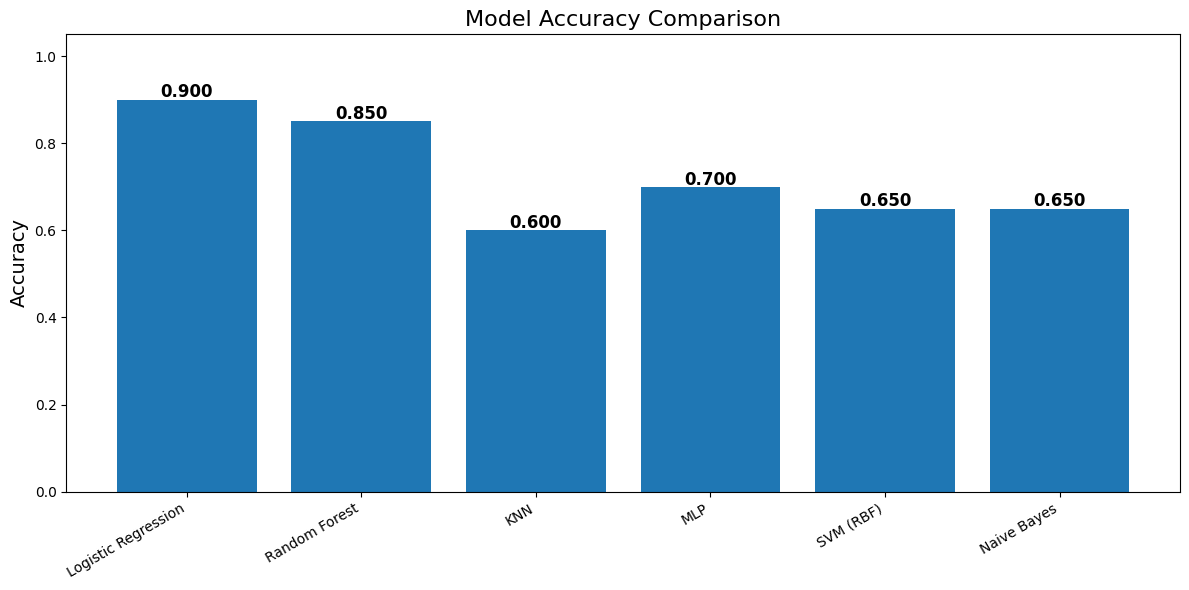

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dictionary of your fitted models from the notebook
models = {
    "Logistic Regression": pipe_log,
    "Random Forest": pipe_rf,
    "KNN": pipe_knn,
    "MLP": pipe_mlp,
    "SVM (RBF)": pipe_svm,
    "Naive Bayes": pipe_nb,
}


# --------------------------------------------
#  CALCULATE ACCURACY FOR EACH MODEL
# --------------------------------------------
accuracies = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)

# --------------------------------------------
#  PLOT BAR CHART
# --------------------------------------------
plt.figure(figsize=(12,6))

bars = plt.bar(accuracies.keys(), accuracies.values())

# Add accuracy text above bars
for bar, value in zip(bars, accuracies.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 0.005,
        f"{value:.3f}",
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()